In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
X = np.stack([np.array(img.numpy()).transpose(1, 2, 0).reshape(-1) for img, _ in dataset]) 
y = np.array([label for _, label in dataset])  # shape: (50000,)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
X_test = np.stack([np.array(img.numpy()).transpose(1, 2, 0).reshape(-1) for img, _ in test_dataset])
y_test = np.array([label for _, label in test_dataset])

X, _, y, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

100%|█████████████████████████| 170498071/170498071 [02:59<00:00, 951701.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=217) 
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [5]:
# 3. Train multinomial logistic regression (softmax)
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
clf.fit(X_pca, y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, multi_class='multinomial')

In [6]:
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_auc_score

y_pred = clf.predict(X_test_pca)
y_proba = clf.predict_proba(X_test_pca)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')  # Requires predict_proba

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision_weighted * 100:.2f}%")
print(f"Recall (Weighted): {recall_weighted * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")

Accuracy: 37.74%
Precision (Weighted): 37.26%
Recall (Weighted): 37.74%
Balanced Accuracy: 37.74%
ROC AUC Score: 80.23%


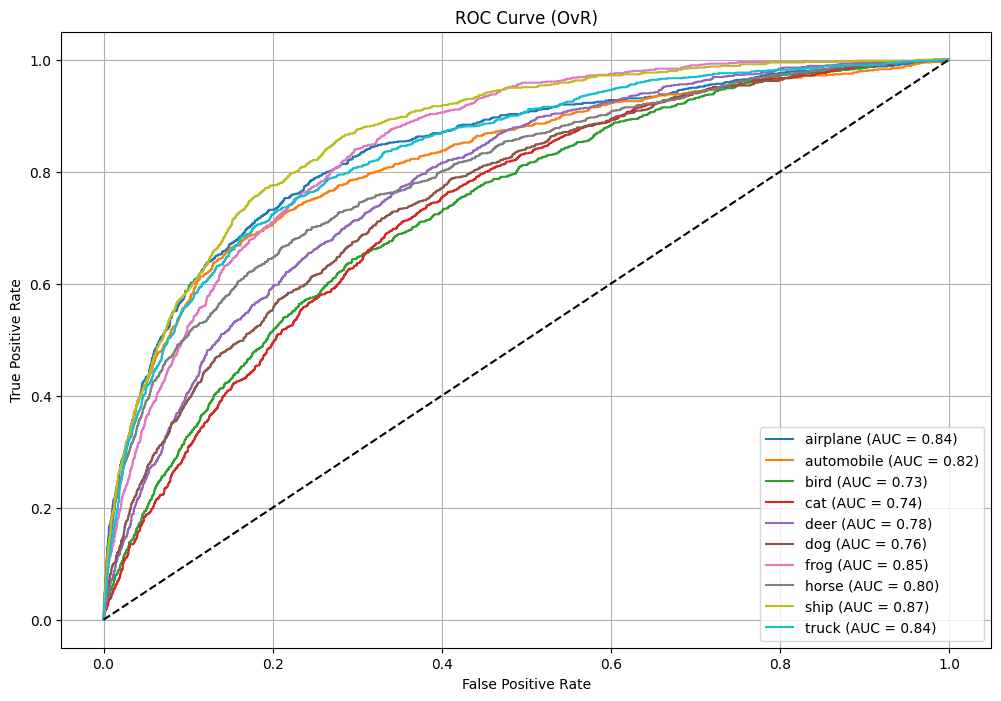

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=range(10))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (OvR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=test_dataset.classes))


              precision    recall  f1-score   support

    airplane       0.43      0.47      0.45      1000
  automobile       0.44      0.45      0.45      1000
        bird       0.27      0.24      0.25      1000
         cat       0.25      0.23      0.24      1000
        deer       0.34      0.29      0.32      1000
         dog       0.31      0.28      0.29      1000
        frog       0.39      0.46      0.42      1000
       horse       0.44      0.43      0.43      1000
        ship       0.44      0.49      0.46      1000
       truck       0.42      0.44      0.43      1000

    accuracy                           0.38     10000
   macro avg       0.37      0.38      0.37     10000
weighted avg       0.37      0.38      0.37     10000



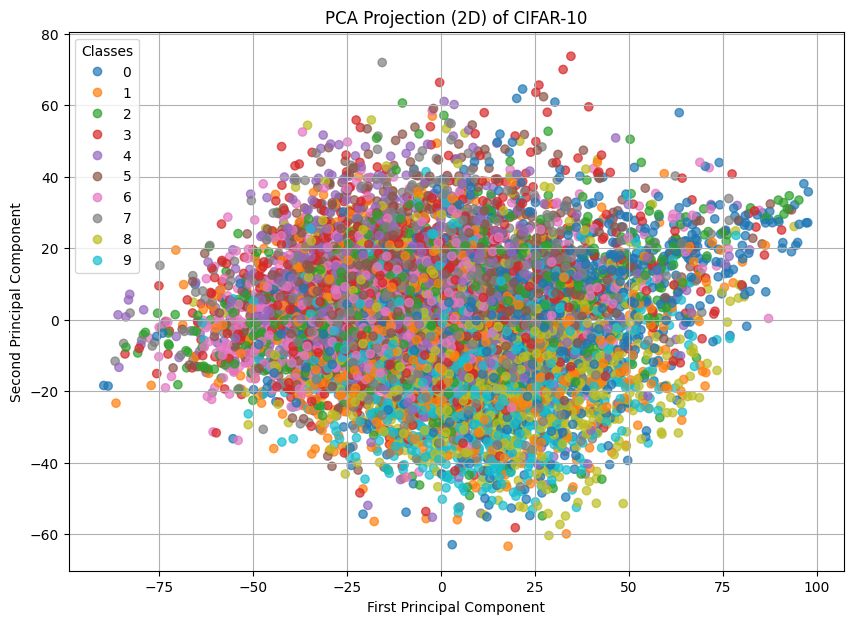

In [10]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('PCA Projection (2D) of CIFAR-10')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()


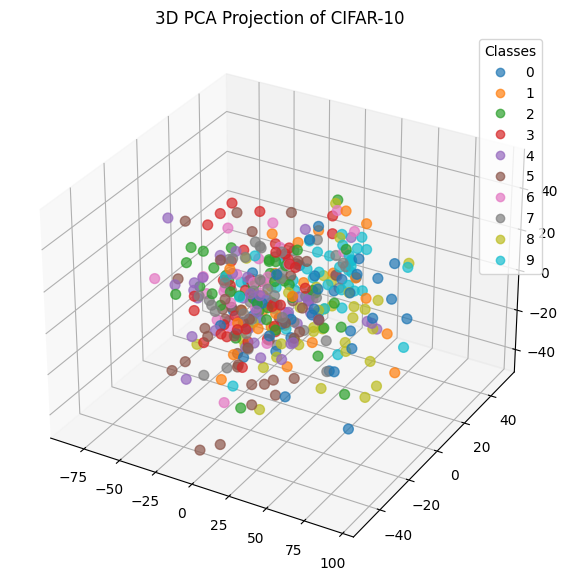

In [25]:
from mpl_toolkits.mplot3d import Axes3D
subset =400
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled[:subset])
y_subset = y[:subset]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=y_subset, cmap='tab10', s=50, alpha=0.7)
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.set_title('3D PCA Projection of CIFAR-10')
plt.show()


In [29]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

subset = 2000
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled[:subset])
y_subset = y[:subset]

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_subset, palette='tab10', s=60)
plt.title('UMAP Projection of CIFAR-10')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'umap.umap_'

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


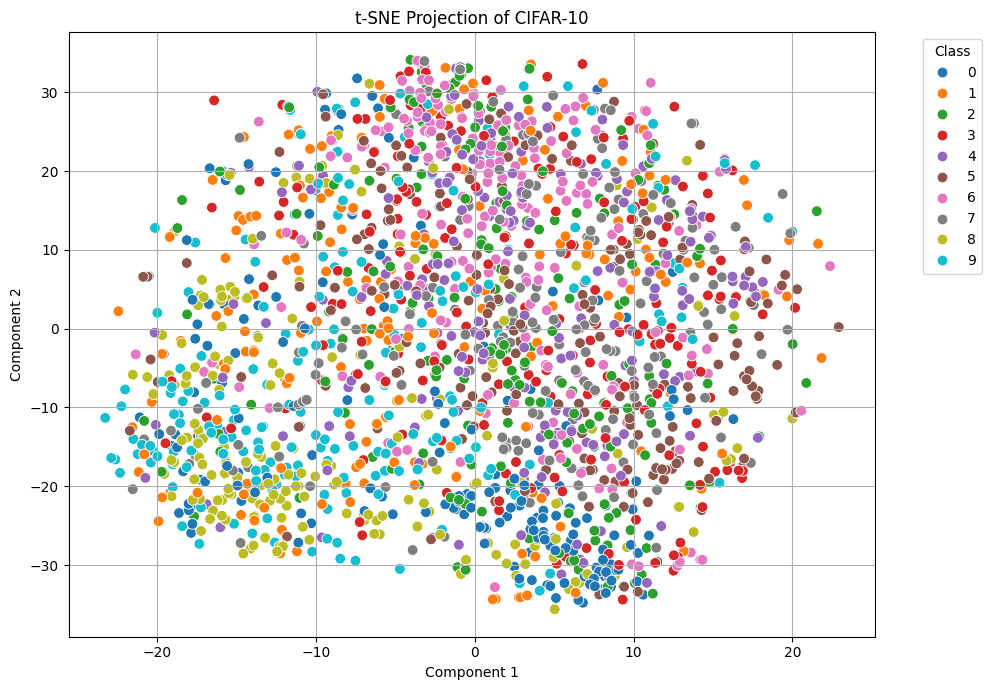

In [30]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# t-SNE takes time, so try a subset (e.g., 2000 samples)
subset = 2000
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled[:subset])
y_subset = y[:subset]

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_subset, palette='tab10', s=60)
plt.title('t-SNE Projection of CIFAR-10')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


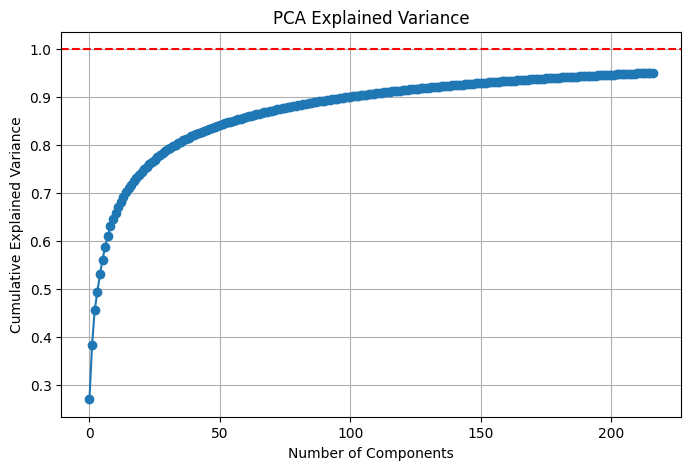

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(1.0, color='red', linestyle='--')
plt.show()


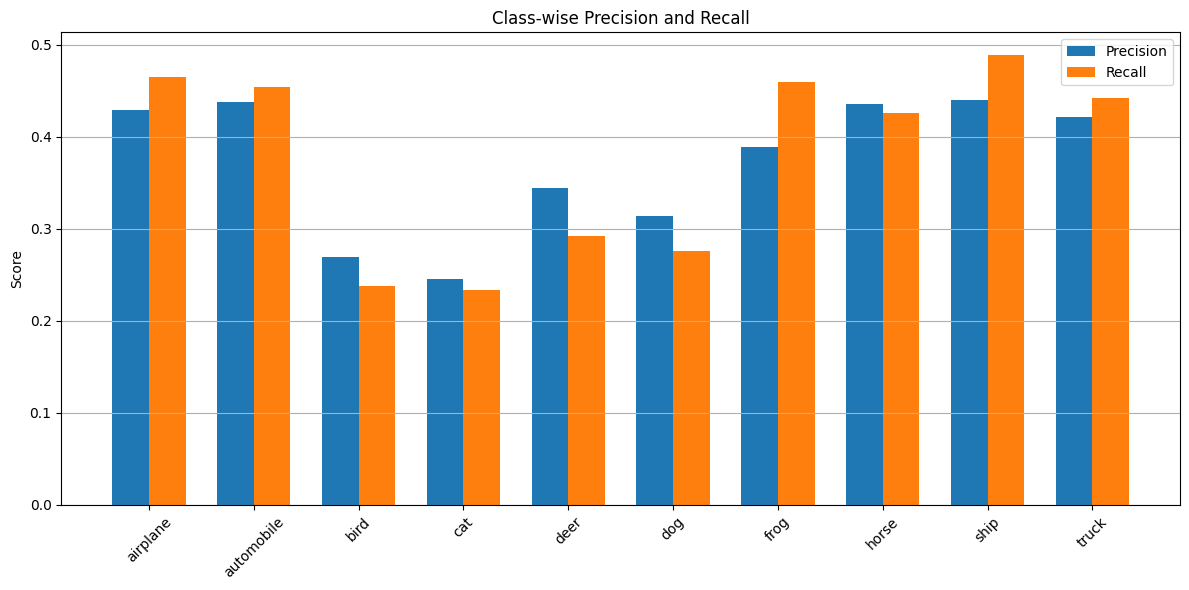

In [11]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

x = np.arange(len(test_dataset.classes))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, precision, width, label='Precision')
plt.bar(x + width/2, recall, width, label='Recall')

plt.ylabel('Score')
plt.title('Class-wise Precision and Recall')
plt.xticks(ticks=x, labels=test_dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()
